# Imports

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdv.evaluation.single_table import get_column_plot

# Load real and synthetic data

In [3]:
combined_data = pd.read_csv("real_data.csv", sep=",")
synthetic_data_sdv = pd.read_csv("synthetic_data_sdv.csv", sep=",")
synthetic_data_gan = pd.read_csv("synthetic_data_gan.csv", sep=",")

In [ ]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(combined_data)

# Measure the statistical similarity between real and synthetic data

## SDV Generated Data

In [ ]:
quality_report = evaluate_quality(
    combined_data,
    synthetic_data_sdv,
    metadata)

In [ ]:
fig = get_column_plot(
    real_data=combined_data,
    synthetic_data=synthetic_data_sdv,
    column_name='source',
    metadata=metadata
)

fig.show()

In [ ]:
fig = get_column_plot(
    real_data=combined_data,
    synthetic_data=synthetic_data_sdv,
    column_name='target',
    metadata=metadata
)

fig.show()

## GAN Generated Data

In [ ]:
quality_report2 = evaluate_quality(
    combined_data,
    synthetic_data_gan,
    metadata)

In [ ]:
fig = get_column_plot(
    real_data=combined_data,
    synthetic_data=synthetic_data_gan,
    column_name='source',
    metadata=metadata
)

fig.show()

In [ ]:
fig = get_column_plot(
    real_data=combined_data,
    synthetic_data=synthetic_data_gan,
    column_name='target',
    metadata=metadata
)

fig.show()

# Link load difference

To further extent the comparison between the real data and the synthetic data, we want to see how much does the link load (demand_value) varies between these two.

To do so, we will follow this approach:
1. For each dataset (real and synthetic), we will create a new dataset that stores, for each unique source-destination pair, the total link load. This is computed by summing up the demand value for each unique pair.
2. Calculate the absolute and relative difference in link loads.

In [ ]:
# Group by source and target
real_clean = combined_data.groupby(["source", "target"])["demand_value"].sum().reset_index()
synthetic_gan_clean = synthetic_data_gan.groupby(["source", "target"])["demand_value"].sum().reset_index()
synthetic_sdv_clean = synthetic_data_sdv.groupby(["source", "target"])["demand_value"].sum().reset_index()

In [24]:
# Filter out rows with same source and destination
synthetic_gan_clean = synthetic_gan_clean[synthetic_gan_clean["source"] != synthetic_gan_clean["target"]]
synthetic_sdv_clean = synthetic_sdv_clean[synthetic_sdv_clean["source"] != synthetic_sdv_clean["target"]]

In [ ]:
# Merge datasets
df_comparison_temp = pd.merge(real_clean, synthetic_gan_clean, 
                         on=["source", "target"],
                         how="outer",
                         suffixes=("_real", "_gan")).fillna(0)

df_comparison = pd.merge(df_comparison_temp, synthetic_sdv_clean,
                         on=["source", "target"],
                         how="outer").fillna(0)

df_comparison.rename(columns={"demand_value": "demand_value_sdv"}, inplace=True)

In [62]:
# Calculate the absolute and relative differences
df_comparison["abs_diff_gan"] = abs(
    df_comparison["demand_value_real"] - df_comparison["demand_value_gan"])
df_comparison["rel_diff_gan"] = df_comparison["abs_diff_gan"] / df_comparison["demand_value_real"]

df_comparison["abs_diff_sdv"] = abs(
    df_comparison["demand_value_real"] - df_comparison["demand_value_sdv"])
df_comparison["rel_diff_sdv"] = df_comparison["abs_diff_sdv"] / df_comparison["demand_value_real"]

In [63]:
df_comparison

,source,target,demand_value_real,demand_value_gan,demand_value_sdv,abs_diff_gan,rel_diff_gan,abs_diff_sdv,rel_diff_sdv
0,ATLAM5,ATLAng,34.648939,5.256096,153.819418,29.392843,0.848304,119.170479,3.439369
1,ATLAM5,CHINng,102.622054,21.501339,352.288974,81.120715,0.790480,249.666920,2.432878
2,ATLAM5,DNVRng,78.282184,77.437285,91.539939,0.844899,0.010793,13.257755,0.169359
3,ATLAM5,HSTNng,20.613127,85.151870,78.250143,64.538743,3.130954,57.637016,2.796132
4,ATLAM5,IPLSng,94.208020,62.392866,484.007680,31.815154,0.337712,389.799660,4.137648
...,...,...,...,...,...,...,...,...,...
127,WASHng,KSCYng,1500.195668,3200.572975,841.571732,1700.377307,1.133437,658.623936,0.439025
128,WASHng,LOSAng,7790.094634,1835.077124,4327.881242,5955.017510,0.764435,3462.213392,0.444438
129,WASHng,NYCMng,15636.497936,6625.325852,14287.946505,9011.172084,0.576291,1348.551431,0.086244
130,WASHng,SNVAng,430.937251,8007.254045,3160.497312,7576.316794,17.581021,2729.560061,6.334008


In [ ]:
mad_gan = df_comparison['abs_diff_gan'].mean()
mrd_gan = df_comparison['rel_diff_gan'].mean()
print(f"Mean Absolute Difference (GAN): {mad_gan}")
print(f"Mean Relative Difference (GAN): {mrd_gan}")
print()

mad_gan = df_comparison['abs_diff_sdv'].mean()
mrd_gan = df_comparison['rel_diff_sdv'].mean()
print(f"Mean Absolute Difference (SDV): {mad_gan}")
print(f"Mean Relative Difference (SDV): {mrd_gan}")

Mean Absolute Difference (GAN): 1579.928164266217
Mean Relative Difference (GAN): 17.939928321606086

Mean Absolute Difference (SDV): 1308.4202992272728
Mean Relative Difference (SDV): 3.9129536077005795


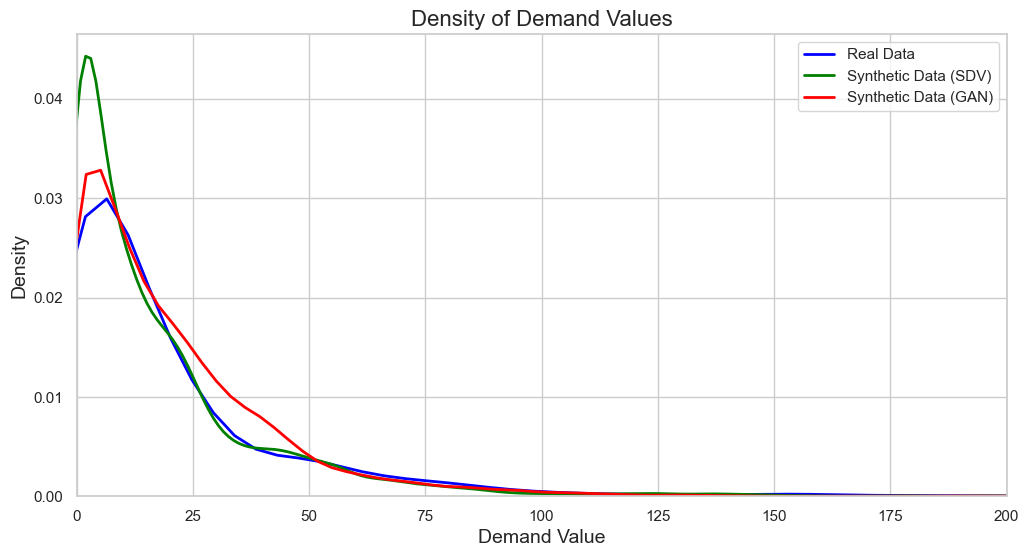

In [77]:
# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure and axis object
plt.figure(figsize=(12, 6))

# Plot the density for 'demand_value' from real and synthetic data
sns.kdeplot(combined_data['demand_value'], color='blue', label='Real Data', linewidth=2)
sns.kdeplot(synthetic_data_sdv['demand_value'], color='green', label='Synthetic Data (SDV)', linewidth=2)
sns.kdeplot(synthetic_data_gan['demand_value'], color='red', label='Synthetic Data (GAN)', linewidth=2)

# Add labels and title
plt.xlim(0, 200)
plt.title('Density of Demand Values', fontsize=16)
plt.xlabel('Demand Value', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()
plt.show()

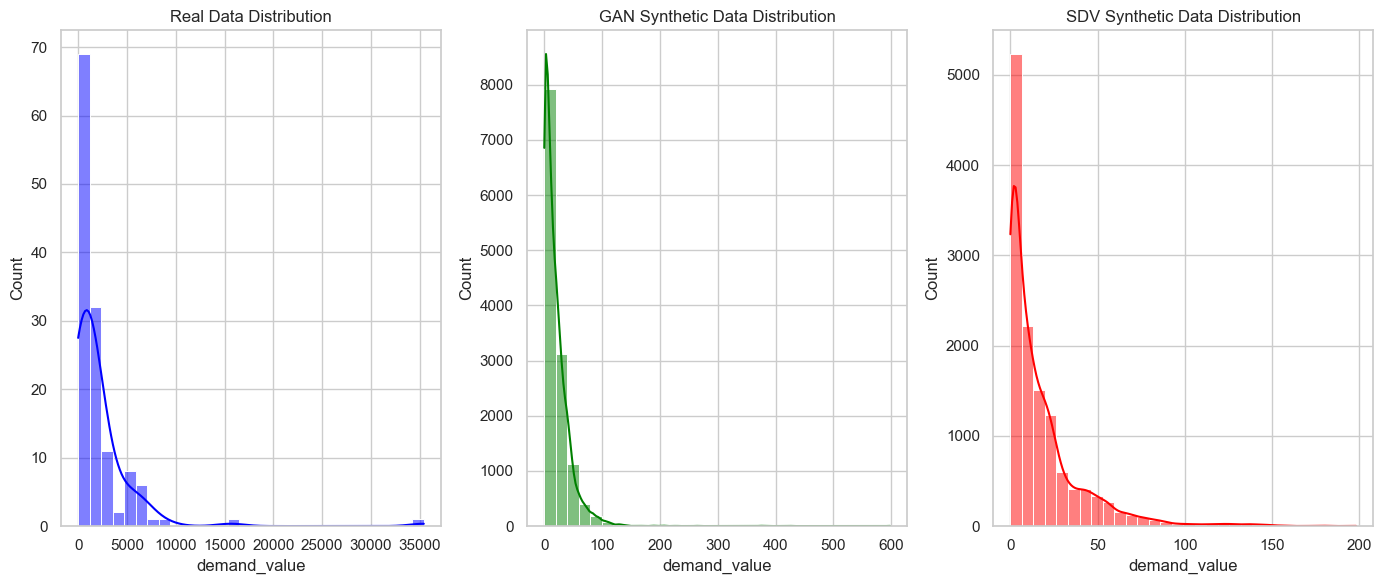

In [78]:
plt.figure(figsize=(14, 6))

# Plot histogram for real data
plt.subplot(1, 3, 1)
sns.histplot(real_clean['demand_value'], kde=True, color='blue', bins=30)
plt.title('Real Data Distribution')

# Plot histogram for GAN synthetic data
plt.subplot(1, 3, 2)
sns.histplot(synthetic_data_gan['demand_value'], kde=True, color='green', bins=30)
plt.title('GAN Synthetic Data Distribution')

# Plot histogram for SDV synthetic data
plt.subplot(1, 3, 3)
sns.histplot(synthetic_data_sdv['demand_value'], kde=True, color='red', bins=30)
plt.title('SDV Synthetic Data Distribution')

plt.tight_layout()
plt.show()